In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from kvae import VariationalAutoencoder

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [3]:
batch_size = 128
latent_dim = 2

intermediate_dims = [512, 256, 128, 64] # 137.45

epochs = 10

In [4]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_dim = x_train.shape[1]

x_train.shape, x_test.shape, input_dim

((60000, 784), (10000, 784), 784)

In [5]:
vae = VariationalAutoencoder(input_dim, intermediate_dims, latent_dim,
                             epsilon_std=0.3)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/home/yannick/Work/github/Spikes/python/kvae.py:88: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer='rmsprop', loss=None)


In [6]:
%%time

from random import seed

seed(42)

history = vae.fit(x_train,
                  shuffle=True,
                  epochs=2,
                  batch_size=batch_size,
                  validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 4s - loss: 188.9005 - val_loss: 167.0522
Epoch 2/2
60000/60000 [==============================] - 3s - loss: 160.5092 - val_loss: 156.1261
CPU times: user 9.24 s, sys: 612 ms, total: 9.85 s
Wall time: 7.68 s


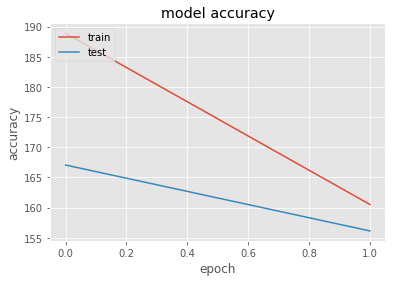

In [7]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='upper left')

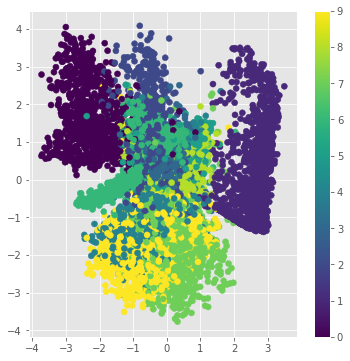

In [8]:
x_test_encoded = vae.encode(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

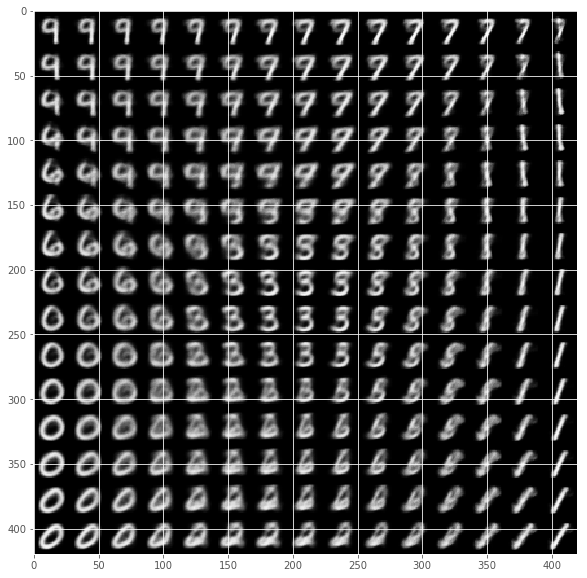

In [9]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.generate(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

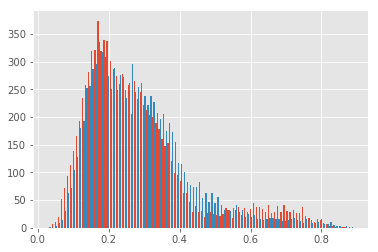

In [10]:
z_sigma_test = vae.sigmaEncode(x_test, batch_size=batch_size)

_ = plt.hist(z_sigma_test, bins=100)